# Intro

Dans cette partie, nous allons traiter/analyser nos données et justifier nos choix pratiques/éthiques au niveau des features choisis.

In [16]:
import pandas as pd
from datetime import datetime

#ouverture Mise en Dataframe des données
employee_survey_data_path = "datas/employee_survey_data.csv"
manager_survey_data_path = "datas/manager_survey_data.csv"
general_data_path = "datas/general_data.csv"
in_time_data_path = "datas/in_time.csv"
out_time_data_path = "datas/out_time.csv"

# employee_survey_data = pd.read_csv(employee_survey_data_path)
# manager_survey_data = pd.read_csv(manager_survey_data_path)
# general_data = pd.read_csv(general_data_path)
in_time_data = pd.read_csv(in_time_data_path)
out_time_data = pd.read_csv(out_time_data_path)

datas_raw = [0]*4

datas_raw[0] = pd.read_csv(employee_survey_data_path)
datas_raw[1] = pd.read_csv(general_data_path)
datas_raw[2] = pd.read_csv(manager_survey_data_path)




def merge_datas(datas):
    merged_datas = datas[0]
    for i in range(len(datas)-1):
        merged_datas = pd.merge(merged_datas, datas[i+1], on='EmployeeID', how='inner')
    return merged_datas


In [17]:
def to_datetime(strdate):
    if type(strdate) == str:
        return datetime.strptime(strdate, "%Y-%m-%d %H:%M:%S").timestamp()
    else:
        return 0



def get_working_time(in_time_data, out_time_data):
    out_time_df = (
        out_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    in_time_df = (
        in_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    hours_per_day = out_time_df - in_time_df
    in_time_data["MeanWorkingHours"] = hours_per_day.mean(axis = 1)/3600
    return in_time_data[["EmployeeID", "MeanWorkingHours"]]

datas_raw[3] = get_working_time(in_time_data, out_time_data)

datas_raw[3]

,EmployeeID,MeanWorkingHours
0,1,6.554356
1,2,6.979604
2,3,6.502698
3,4,6.477067
4,5,7.515375
...,...,...
4405,4406,7.934534
4406,4407,5.626061
4407,4408,6.820812
4408,4409,8.765193


merging:

In [3]:
datas = merge_datas(datas_raw)

# Filtre Ethique
ici, on enleve les features ethiquement discutables. On a identifié:
- age
- Gender
- MaritalStatus

In [4]:
datas.drop(columns=["Age","Gender","MaritalStatus"], axis=1, inplace=True, errors="ignore")
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Attrition                4410 non-null   object 
 5   BusinessTravel           4410 non-null   object 
 6   Department               4410 non-null   object 
 7   DistanceFromHome         4410 non-null   int64  
 8   Education                4410 non-null   int64  
 9   EducationField           4410 non-null   object 
 10  EmployeeCount            4410 non-null   int64  
 11  JobLevel                 4410 non-null   int64  
 12  JobRole                  4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [5]:
#import numpy as np
from sklearn.preprocessing import OrdinalEncoder


mapping_dict = {'Non-Travel': 1, 'Travel_Rarely': 2, 'Travel_Frequently': 3}

datas['BusinessTravel'] = datas['BusinessTravel'].map(mapping_dict)


# encoder.fit()

In [6]:
mapping_dict = {'No': 0, 'Yes': 1}
datas['Attrition'] = datas['Attrition'].map(mapping_dict)

datas

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,MeanWorkingHours
0,1,3.0,4.0,2.0,0,2,Sales,6,2,Life Sciences,...,8,0,1.0,6,1,0,0,3,3,6.554356
1,2,3.0,2.0,4.0,1,3,Research & Development,10,1,Life Sciences,...,8,1,6.0,3,5,1,4,2,4,6.979604
2,3,2.0,2.0,1.0,0,3,Research & Development,17,4,Other,...,8,3,5.0,2,5,0,3,3,3,6.502698
3,4,4.0,4.0,3.0,0,1,Research & Development,2,5,Life Sciences,...,8,3,13.0,5,8,7,5,2,3,6.477067
4,5,4.0,1.0,3.0,0,2,Research & Development,10,1,Medical,...,8,2,9.0,2,6,0,4,3,3,7.515375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,4.0,1.0,3.0,0,2,Research & Development,5,4,Medical,...,8,1,10.0,5,3,0,2,3,3,7.934534
4406,4407,4.0,4.0,3.0,0,2,Research & Development,2,4,Medical,...,8,0,10.0,2,3,0,2,2,3,5.626061
4407,4408,1.0,3.0,3.0,0,2,Research & Development,25,2,Life Sciences,...,8,0,5.0,4,4,1,2,3,4,6.820812
4408,4409,4.0,1.0,3.0,0,2,Sales,18,2,Medical,...,8,1,10.0,2,9,7,8,2,3,8.765193


En explorant nos données, on remarque qu'il y a des données uniques pour toutes nos itérations:

In [7]:

#clean les donnees string ici avant ce bloc!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#datas.hist(bins=50, figsize=(20,15))

on peut donc enlever:
- EmployeeCount
- Over18
- StandardHours

In [8]:
datas.drop(columns=["EmployeeCount","Over18","StandardHours"], errors="ignore", inplace=True)
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Attrition                4410 non-null   int64  
 5   BusinessTravel           4410 non-null   int64  
 6   Department               4410 non-null   object 
 7   DistanceFromHome         4410 non-null   int64  
 8   Education                4410 non-null   int64  
 9   EducationField           4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  PercentSalaryHike       

Faisons maintenant des OneHotEncoders des données string restantes

In [9]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
encoded_datas_array = one_hot_encoder.fit_transform(datas[[
    "EducationField", "Department", "JobRole",]]).toarray()
encoded_datas_labels = one_hot_encoder.categories_
encoded_datas_labels = np.hstack([
    ["EducationField_" + x for x in encoded_datas_labels[0]],
    ["Department_" + x for x in encoded_datas_labels[1]],
    ["JobRole_" + x for x in encoded_datas_labels[2]]
    ])
encoded_data = pd.DataFrame(encoded_datas_array, columns=encoded_datas_labels)
#encoded_data["EmployeeID"] = datas["EmployeeID"]


datas = datas.join(encoded_data)
datas.drop(['EducationField', 'Department', "JobRole"], axis=1, inplace=True, errors="ignore")
datas.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EmployeeID                         4410 non-null   int64  
 1   EnvironmentSatisfaction            4385 non-null   float64
 2   JobSatisfaction                    4390 non-null   float64
 3   WorkLifeBalance                    4372 non-null   float64
 4   Attrition                          4410 non-null   int64  
 5   BusinessTravel                     4410 non-null   int64  
 6   DistanceFromHome                   4410 non-null   int64  
 7   Education                          4410 non-null   int64  
 8   JobLevel                           4410 non-null   int64  
 9   MonthlyIncome                      4410 non-null   int64  
 10  NumCompaniesWorked                 4391 non-null   float64
 11  PercentSalaryHike                  4410 non-null   int64

# Vérification d'exhaustivité
Dans un premier temps, on regarde les données pour voir s'il y a des features manquantes pour certaines instances.

In [10]:
datas = datas.dropna(subset=datas.columns)
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EmployeeID                         4300 non-null   int64  
 1   EnvironmentSatisfaction            4300 non-null   float64
 2   JobSatisfaction                    4300 non-null   float64
 3   WorkLifeBalance                    4300 non-null   float64
 4   Attrition                          4300 non-null   int64  
 5   BusinessTravel                     4300 non-null   int64  
 6   DistanceFromHome                   4300 non-null   int64  
 7   Education                          4300 non-null   int64  
 8   JobLevel                           4300 non-null   int64  
 9   MonthlyIncome                      4300 non-null   int64  
 10  NumCompaniesWorked                 4300 non-null   float64
 11  PercentSalaryHike                  4300 non-null   int64

# Scaling
Ici, nous allons mettre toutes nos valeurs sur la même échelle. 

In [11]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(datas)
datas_scaled = pd.DataFrame(std_scale.transform(datas), columns=datas.columns)

# Etude de corrélation

Attrition                            1.000000
MeanWorkingHours                     0.195102
BusinessTravel                       0.122725
EducationField_Human Resources       0.089159
Department_Human Resources           0.074338
JobRole_Research Director            0.044520
NumCompaniesWorked                   0.043911
PercentSalaryHike                    0.034425
JobRole_Research Scientist           0.030277
PerformanceRating                    0.026262
EducationField_Life Sciences         0.012283
JobRole_Sales Executive              0.011370
JobRole_Laboratory Technician       -0.000584
EmployeeID                          -0.001707
EducationField_Medical              -0.001983
EducationField_Marketing            -0.003655
StockOptionLevel                    -0.007971
JobRole_Sales Representative        -0.008109
DistanceFromHome                    -0.008314
JobRole_Human Resources             -0.013227
JobRole_Healthcare Representative   -0.013255
Department_Research & Development 

<AxesSubplot:>

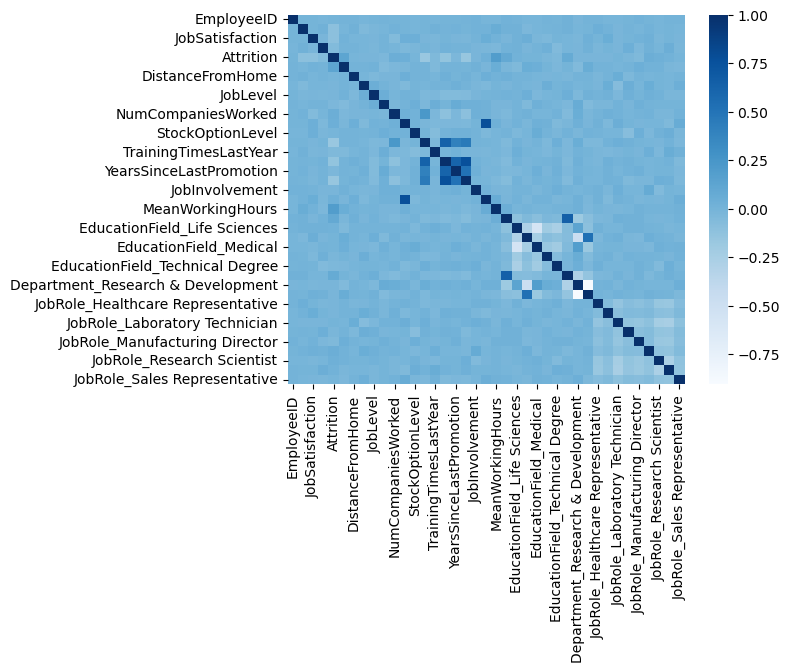

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr =datas_scaled.corr()
print(corr["Attrition"].sort_values(ascending=False))
sns.heatmap(corr, cmap=plt.cm.Blues)

<AxesSubplot:>

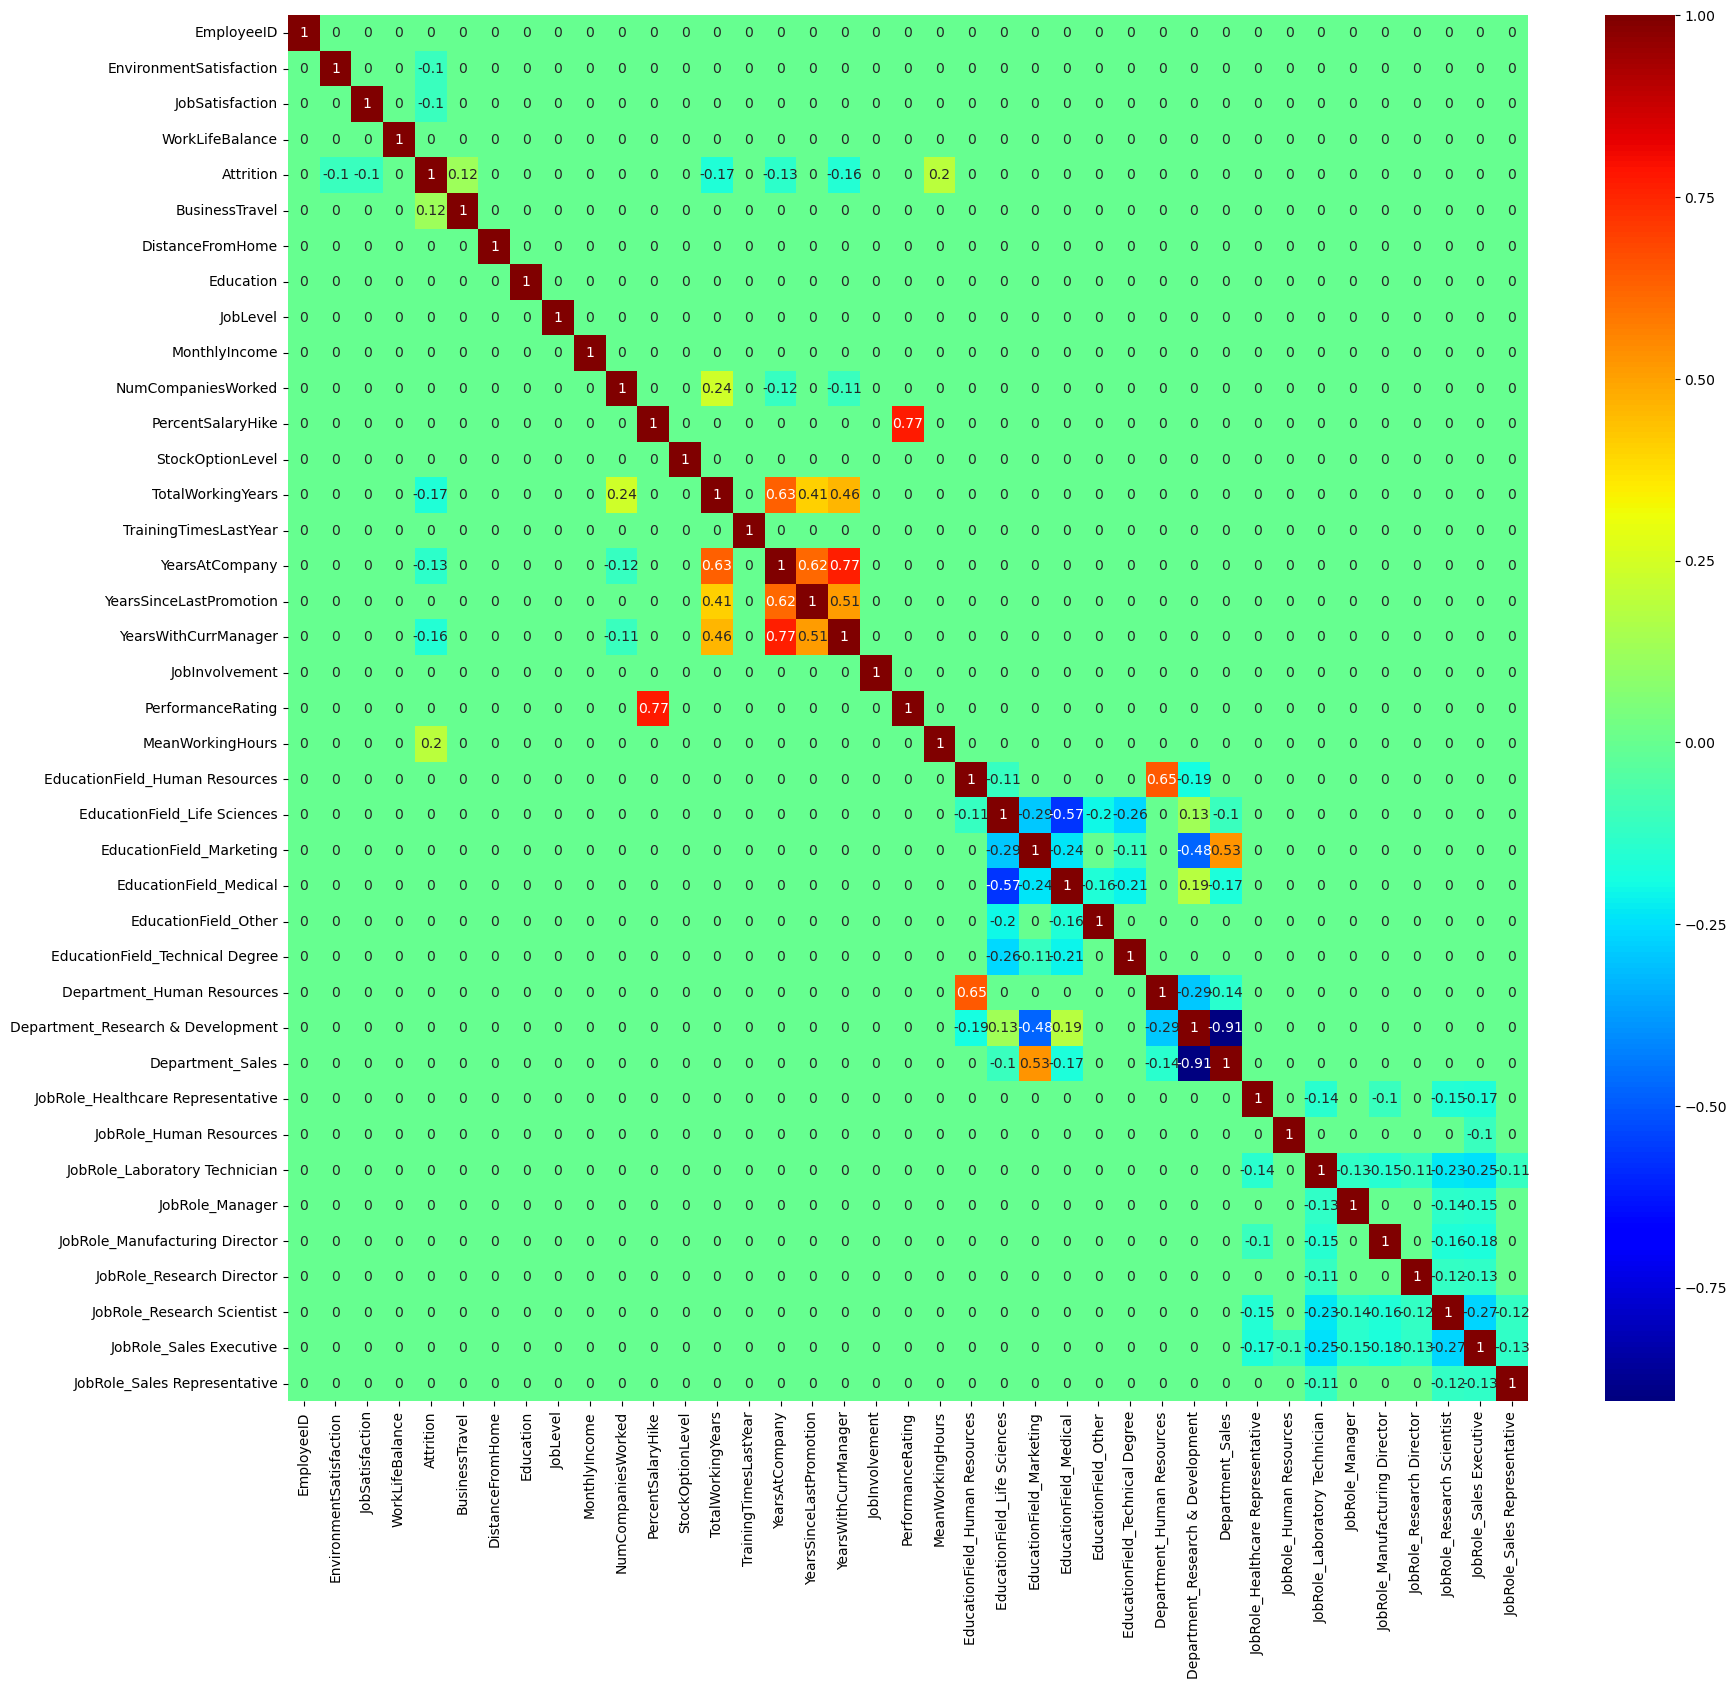

In [13]:
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if abs(corr.iloc[i, j]) < 0.1:
            corr.iloc[i, j] = 0

plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True, cmap=plt.get_cmap("jet"))

Après analyse, nous prévoyons de garder:
- MeanWorkingHours
- BusinessTravel
- EducationField_Human Resources
- WorkLifeBalance
- JobSatisfaction
- EnvironmentSatisfaction
- YearsAtCompany
- YearsWithCurrManager
- TotalWorkingYears


Avant de continuer, mettons nos données dans un nouveau CSV (dans le cas ou on veut recharger nos données directement nettoyées).

In [37]:
datas_scaled.drop("Attrition", axis=1, inplace=True, errors="ignore")
datas_scaled.drop("EmployeeID", axis=1, inplace=True, errors="ignore")
datas_scaled.to_csv('datas/cleanedData.csv', index=False)

In [38]:
datas["Attrition"].to_csv('datas/labels.csv', index=False)

# Création du jeu d'entrainement et de test

In [2]:
import pandas as pd 
cleaned_datas = pd.read_csv("datas/cleanedData.csv")
labels = pd.read_csv("datas/labels.csv")

Creation de la fonction:

In [4]:
from sklearn.model_selection import train_test_split

def train_test_creation(x:pd.DataFrame,y:pd.DataFrame, features=[], test_size=0.3):
    """
    Pour appeler la fonction:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"])

    Pour appeler la fonction en precisant les features:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], features=["feature1","feature2","..."])

    Pour appeler la fonction en précisant le test_size:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], test_size=0.2)

    """
    # X_train, X_test, y_train, y_test = None
    if(len(features)==0):
        X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=test_size, shuffle=True, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split( x[features], y, test_size=test_size, shuffle=True)
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    return X_train, X_test, y_train, y_test




appel de la fonction:

In [5]:
X_train, X_test, y_train, y_test = train_test_creation(cleaned_datas, labels["Attrition"])

# Selection des modèles
## Entrainement

In [6]:
#imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

#classifiers creation
svc_clf = SVC()
sgd_clf = SGDClassifier()
rf_clf = RandomForestClassifier()
Perceptron_clf = Perceptron()
tree_clf = DecisionTreeClassifier()

#training
svc_clf.fit(X_train,y_train)
sgd_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
Perceptron_clf.fit(X_train,y_train)
tree_clf.fit(X_train,y_train)






DecisionTreeClassifier()

## Scoring

In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

#scoring
svc_clf_score = cross_val_predict(svc_clf,X_train, y_train, cv=4)
sgd_clf_score = cross_val_predict(sgd_clf,X_train, y_train, cv=4)
rf_clf_score = cross_val_predict(rf_clf,X_train, y_train, cv=4)
Perceptron_clf_score = cross_val_predict(Perceptron_clf,X_train, y_train, cv=4)
tree_clf_score = cross_val_predict(tree_clf,X_train, y_train, cv=4)

#Printing score
def print_score(y, s):
    """
    y: labels
    s: predictions
    """
    print(f"precision : {precision_score(y, s)}")
    print(f"recall : {recall_score(y, s)}")
    print(f"f1 : {f1_score(y, s)}")
    print("confusion matrix:")
    print(confusion_matrix(y, s))


print("SVC:")
print_score(y_train, svc_clf_score)
print("----------------------------------------------")
print("SGD Classifier:")
print_score(y_train, sgd_clf_score)
print("----------------------------------------------")
print("RANDOM FOREST:")
print_score(y_train, rf_clf_score)
print("----------------------------------------------")
print("PERCEPTRON:")
print_score(y_train, Perceptron_clf_score)
print("----------------------------------------------")
print("DECISION TREE:")
print_score(y_train, tree_clf_score)
print("----------------------------------------------")

SVC:
precision : 0.9375
recall : 0.3395061728395062
f1 : 0.4984894259818731
confusion matrix:
[[2513   11]
 [ 321  165]]
----------------------------------------------
SGD Classifier:
precision : 0.385
recall : 0.15843621399176955
f1 : 0.22448979591836735
confusion matrix:
[[2401  123]
 [ 409   77]]
----------------------------------------------
RANDOM FOREST:
precision : 0.9748743718592965
recall : 0.7983539094650206
f1 : 0.8778280542986424
confusion matrix:
[[2514   10]
 [  98  388]]
----------------------------------------------
PERCEPTRON:
precision : 0.30111524163568776
recall : 0.3333333333333333
f1 : 0.31640625
confusion matrix:
[[2148  376]
 [ 324  162]]
----------------------------------------------
DECISION TREE:
precision : 0.7736220472440944
recall : 0.808641975308642
f1 : 0.7907444668008048
confusion matrix:
[[2409  115]
 [  93  393]]
----------------------------------------------


roc curves:

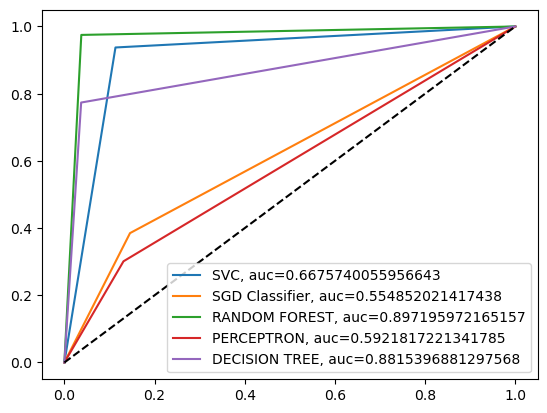

In [8]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

def plot_roc(y, s, name:str):
    """
    y: labels
    s: predictions
    """
    fpr, tpr, thresh = metrics.roc_curve(s, y)
    auc = metrics.roc_auc_score(y, s)
    plt.plot(fpr,tpr,label=f"{name}, auc="+str(auc))

plot_roc(y_train, svc_clf_score,"SVC")
plot_roc(y_train, sgd_clf_score,"SGD Classifier")
plot_roc(y_train, rf_clf_score,"RANDOM FOREST")
plot_roc(y_train, Perceptron_clf_score,"PERCEPTRON")
plot_roc(y_train, tree_clf_score,"DECISION TREE")

plt.plot([0, 1], [0, 1], 'k--') #diagonale
plt.legend(loc=0)

En comparant nos AUC, nous avons choisis deux modèles pour aller plus loin:
- Random Forest
- Decision Tree

Dans la partie suivante, nous allons utiliser un grid search pour optimiser les hyperparamètres de nos modèles

# Fine Tuning

Ici, nous allons utiliser un grid search pour optimiser les hyperparamètres de nos modèles. L'objectif est donc de trouver les meilleurs hyperparamètres pour les deux modèles choisis.

In [16]:
from sklearn.model_selection import GridSearchCV

depth_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, None]

tree_grid = [
    {'max_depth': depth_list, 'criterion': ['gini', 'entropy']}
  ]

forest_grid = [
    
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_search = GridSearchCV(rf_clf, forest_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
forest_search.fit(X_train, y_train)
tree_search = GridSearchCV(tree_clf, tree_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
tree_search.fit(X_train, y_train)

print("random_forest:")
print(forest_search.best_params_)
print("decision_tree:")
print(tree_search.best_params_)


attributes = cleaned_datas.columns
feature_importances = forest_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)


random_forest:
{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
decision_tree:
{'criterion': 'entropy', 'max_depth': 40}


[(0.08933025289239709, 'MeanWorkingHours'),
 (0.08252454189085291, 'TotalWorkingYears'),
 (0.07057073086232, 'MonthlyIncome'),
 (0.066388251489045, 'DistanceFromHome'),
 (0.062380670082103726, 'YearsAtCompany'),
 (0.058491839560109414, 'PercentSalaryHike'),
 (0.044271674056939825, 'EnvironmentSatisfaction'),
 (0.04240365128180264, 'NumCompaniesWorked'),
 (0.04045590921828168, 'YearsSinceLastPromotion'),
 (0.03785210385641473, 'JobSatisfaction'),
 (0.03777655128180469, 'TrainingTimesLastYear'),
 (0.03691025517756964, 'YearsWithCurrManager'),
 (0.03602926102820309, 'WorkLifeBalance'),
 (0.03108294877114055, 'Education'),
 (0.030104915706422923, 'JobLevel'),
 (0.029668820220248644, 'JobInvolvement'),
 (0.025621351229291593, 'StockOptionLevel'),
 (0.022972421541637082, 'BusinessTravel'),
 (0.016029311478460217, 'JobRole_Sales Executive'),
 (0.01299104016109262, 'EducationField_Life Sciences'),
 (0.011503928172218913, 'Department_Sales'),
 (0.010653447872359115, 'JobRole_Research Scientist'

plus qu'a recréer des estimateur avec les bons paramètres:

DECISION TREE:
precision : 0.8559837728194726
recall : 0.8683127572016461
f1 : 0.8621041879468845
confusion matrix:
[[2453   71]
 [  64  422]]
----------------------------------------------
RANDOM FOREST:
precision : 0.9813084112149533
recall : 0.8641975308641975
f1 : 0.9190371991247265
confusion matrix:
[[2516    8]
 [  66  420]]
----------------------------------------------


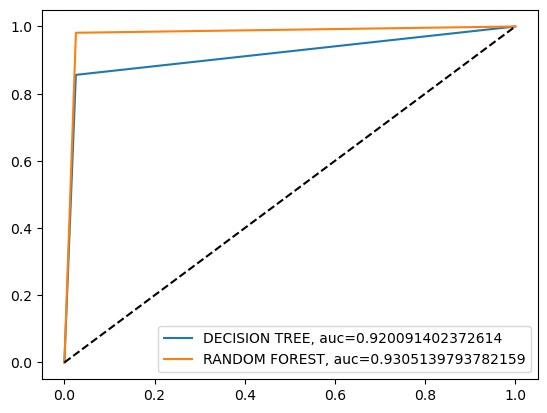

In [19]:
#init
tuned_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=40)
tuned_rf = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=10)

#training
tuned_decision_tree.fit(X_train,y_train)
tuned_rf.fit(X_train,y_train)

#scoring
opti_decision_tree_score = cross_val_predict(tuned_decision_tree,X_train, y_train, cv=10)
opti_rf_score = cross_val_predict(tuned_rf,X_train, y_train, cv=10)



print("DECISION TREE:")
print_score(y_train, opti_decision_tree_score)
print("----------------------------------------------")
print("RANDOM FOREST:")
print_score(y_train, opti_rf_score)
print("----------------------------------------------")

plot_roc(y_train, opti_decision_tree_score,"DECISION TREE")
plot_roc(y_train, opti_rf_score,"RANDOM FOREST")

plt.plot([0, 1], [0, 1], 'k--') #diagonale
plt.legend(loc=0)

# Pipeline finale
Chargement des données

In [39]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

def load_data(file):
    return pd.read_csv(file)

path = "datas/"
general_data = load_data(path +"general_data.csv")
employee_survey_data = load_data(path +"employee_survey_data.csv")
manager_survey_data = load_data(path +"manager_survey_data.csv")
in_time = load_data(path +"in_time.csv")
out_time = load_data(path +"out_time.csv")

définition des fonctions et classes:

In [40]:
def print_score(y, s):
    """
    y: labels
    s: predictions
    """
    print(f"precision : {precision_score(y, s)}")
    print(f"recall : {recall_score(y, s)}")
    print(f"f1 : {f1_score(y, s)}")
    print("confusion matrix:")
    print(confusion_matrix(y, s))
    
def to_datetime(strdate):
    if type(strdate) == str:
        return datetime.strptime(strdate, "%Y-%m-%d %H:%M:%S").timestamp()
    else:
        return 0

def get_working_time(in_time_data, out_time_data):
    out_time_df = (
        out_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    in_time_df = (
        in_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    hours_per_day = out_time_df - in_time_df
    in_time_data["MeanWorkingHours"] = hours_per_day.mean(axis = 1)/3600
    return in_time_data[["EmployeeID", "MeanWorkingHours"]]


class MergeDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, employee_survey_data, manager_survey_data, in_time, out_time):
        self.employee_survey_data = employee_survey_data
        self.manager_survey_data = manager_survey_data
        self.in_time= in_time
        self.out_time = out_time
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.join(self.employee_survey_data.set_index("EmployeeID"), on="EmployeeID")
        X = X.join(self.manager_survey_data.set_index("EmployeeID"), on="EmployeeID")
        X = pd.merge(X, get_working_time(in_time, out_time), on='EmployeeID', how='inner')

        return X
    
class DeleteUnEthicColumn(BaseEstimator, TransformerMixin):
    def __init__(self, array):
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for i in self.array:
            X.drop(i, axis=1, inplace=True)
        return X


class OrgDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["Attrition"] = X["Attrition"].replace(to_replace=['No', 'Yes'], value=[-1, 1])
        X["BusinessTravel"] = X["BusinessTravel"].replace(to_replace=['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'], value=[1, 2, 3])
        return X

from sklearn.model_selection import train_test_split

def train_test_creation(x:pd.DataFrame,y:pd.DataFrame, features=[], test_size=0.3):
    """
    Pour appeler la fonction:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"])

    Pour appeler la fonction en precisant les features:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], features=["feature1","feature2","..."])

    Pour appeler la fonction en précisant le test_size:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], test_size=0.2)

    """
    # X_train, X_test, y_train, y_test = None
    if(len(features)==0):
        X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=test_size, shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split( x[features], y, test_size=test_size, shuffle=True)
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        X_test = X_test.to_numpy()
        y_test = y_test.to_numpy()

    return X_train, X_test, y_train, y_test


In [41]:
def build_pipeline(X):

#Pipeline one for preparation
    #Merge all files in one and change in and out datetime
    prepa_pipeline= Pipeline([
        ("merge", MergeDataFrame(load_data(path +"employee_survey_data.csv"),
                                 load_data(path +"manager_survey_data.csv"),
                                 load_data(path +"in_time.csv"),
                                 load_data(path +"out_time.csv"))),
        #delete useless columns and unEthic
        ("delete", DeleteUnEthicColumn([
                                        "Age",
                                        "Over18",
                                        "Gender",
                                        "MaritalStatus",
                                        "EmployeeCount",
                                        "StandardHours",
                                        "EmployeeID"
        
        ])),
        #encode Attrition and BusinessTravel columns
        ("label",OrgDataFrame()),
    ])
    #create a DataFrame with pipeline 
    data_pipeline = prepa_pipeline.fit_transform(X)

    #create label for classification
    y = data_pipeline['Attrition']
    
    #list all columns who are object to onehot encode them
    object_attribs= data_pipeline.drop(columns=['Attrition','BusinessTravel'],axis=1).select_dtypes(include=["object"]).keys()

    #list all columns who are number to scale them
    num_search = data_pipeline.select_dtypes(include=[np.number])
    num_attribs = list(num_search)

    #create onehot encode step pipeline   
    onehot_pipeline = Pipeline(steps=[
        ('onehot',OneHotEncoder())
    ])
    #create scale step pipeline
    scale_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    #create column transformers 
    pipeline = ColumnTransformer(transformers=[
        ("numerisation",scale_pipeline,num_attribs),
        ("one", onehot_pipeline, object_attribs) 
        ],
        remainder='drop',
        n_jobs=-1)

    #create final pipeline
    full_pipeline = Pipeline(steps=[
        ("pipeline", pipeline),
    ])

    #print pipeline
    from sklearn import set_config
    set_config(display='diagram')
    display(full_pipeline)
    
    #execute pipeline
    data_fullpipeline = full_pipeline.fit_transform(data_pipeline)
    


    #get all columns name to recreate index on dataFrame
    cols_names=full_pipeline.named_steps["pipeline"].named_transformers_["one"].named_steps["onehot"].get_feature_names_out(object_attribs)
    all_cols=np.concatenate([num_attribs,cols_names])
    data_fullpipeline=pd.DataFrame(data_fullpipeline,columns=all_cols)
    
    #create unlabeled dataset
    X = data_fullpipeline.drop(columns=['Attrition'],axis=1)
    tuned_rf = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=10)
    X_train, X_test, y_train, y_test = train_test_creation(X,y)

    model = tuned_rf.fit(X_train,y_train)
    

    
    return model, X_test, y_test

Mise de nos datas dans la Pipeline

In [42]:
model, X_test, y_test = build_pipeline(general_data)

Pipeline(steps=[('pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerisation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Attrition',
                                                   'BusinessTravel',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'MeanWorkingHours']),
                                                 ('one',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['Department', 'EducationField', 'JobRole'], dtype='object'))]))])

In [43]:
predictions=model.predict(X_test)
print_score(y_test,predictions)

precision : 0.9746192893401016
recall : 0.9795918367346939
f1 : 0.9770992366412213
confusion matrix:
[[1122    5]
 [   4  192]]
